# Fisher Information-based sensitivity analysis (MNIST demo)

In [1]:
import torch
from torch import nn, Tensor
import torchvision
import matplotlib.pyplot as plt
import copy
import tqdm
import matplotlib
matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False})

## Standard training

In [2]:
data = torchvision.datasets.MNIST("data", download=True)
images = (data.data / 255)
targets = data.targets

100%|██████████████████████████████████████| 5000/5000 [00:05<00:00, 933.02it/s]


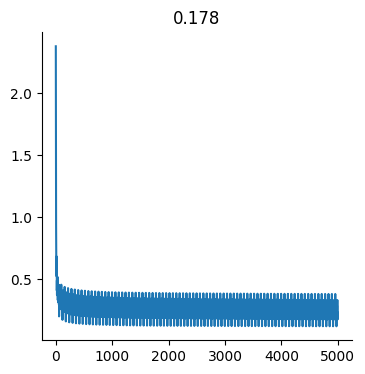

In [96]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.predict = nn.Parameter(torch.randn(28*28, 10) / 28)
        self._x = None
        self._y = None

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        self._x = x.flatten(start_dim=1)
        self._y = (self._x @ self.predict)
        if self._y.requires_grad:
            self._y.retain_grad()
        return nn.functional.cross_entropy(self._y, t)

model = Model()
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
B = 1000
log = []
for i in tqdm.tqdm(list(range(5000))):
    opt.zero_grad()
    idx = (B*i)%images.shape[0]
    loss = model(images[idx:idx+B], targets[idx:idx+B])
    loss.backward()
    opt.step()
    log.append(loss.item())

_, ax = plt.subplots(figsize=(5, 3))
ax.plot(log)
ax.set_title(f"{torch.tensor(log[-10]).mean():.3f}");

## Sensitivity

In [125]:
sensitivity_map = torch.full_like(model.predict, -torch.inf)

delta = model.predict.std()
n = images.shape[0]#10000
ref = model(images[:n], targets[:n])
model._x = model._y = None
model2 = copy.deepcopy(model)
with torch.no_grad():
    for idx in tqdm.tqdm(list(range(model.predict.nelement()))):
        m = sensitivity_map.flatten()
        for d in [delta, -delta]:
            model2.predict.data[...] = model.predict
            model2.predict.data.flatten()[idx] += d
            m[idx] = torch.maximum(m[idx], model2(images[:n], targets[:n]) - ref)

100%|███████████████████████████████████████| 7840/7840 [01:56<00:00, 67.45it/s]


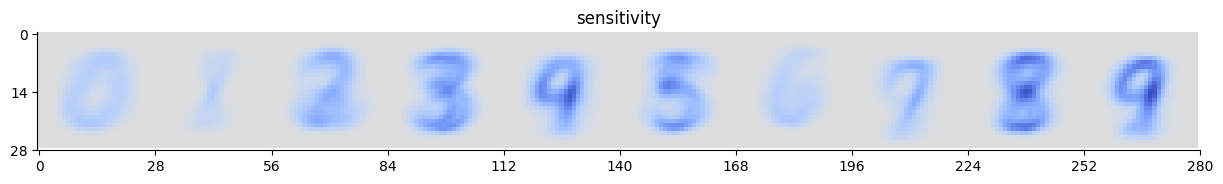

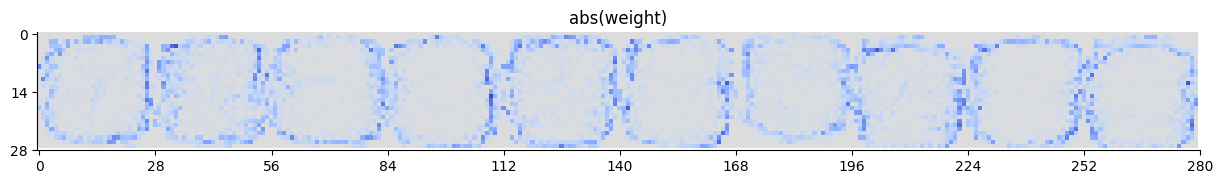

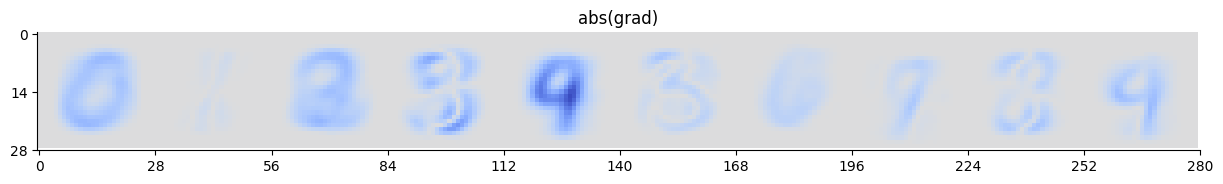

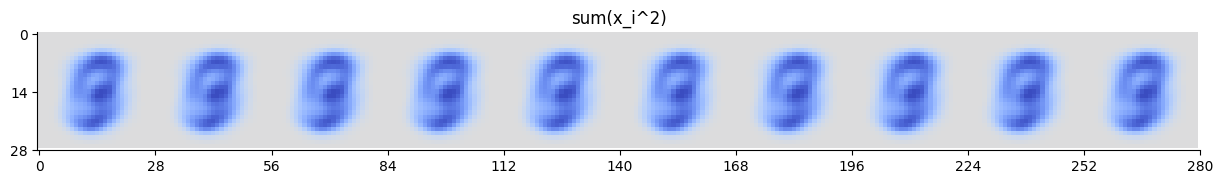

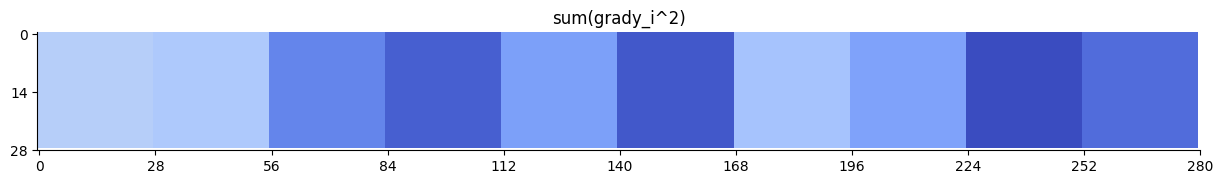

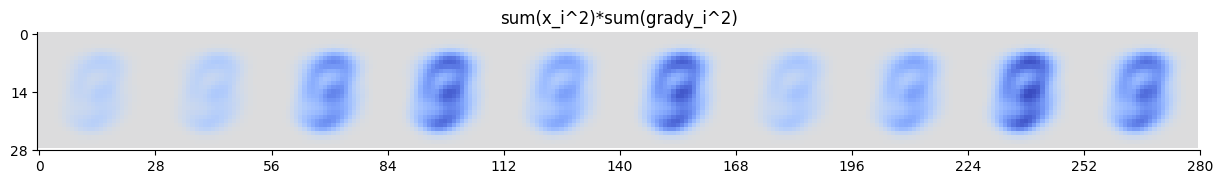

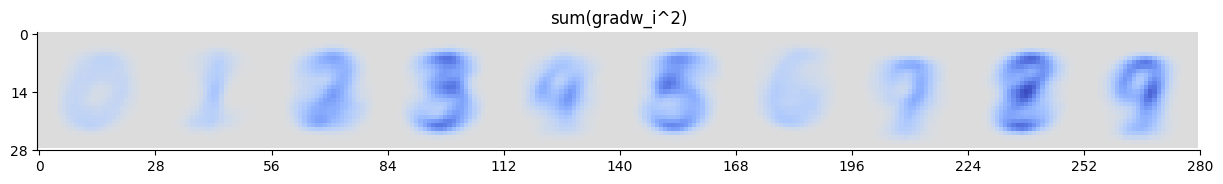

In [126]:
model.zero_grad()
loss = model(images, targets)
loss.backward()
sum_gradw2 = (model._x.pow(2).T @ model._y.grad.pow(2))
sum_x2 = torch.tile(model._x.pow(2).sum(0).view(28, 28, 1), (1, 1, 10))
sum_grady2 = torch.tile(model._y.grad.pow(2).sum(0).view(1, 1, 10), (28, 28, 1))

def showw(t: Tensor) -> matplotlib.axes.Axes:
    _, ax = plt.subplots(figsize=(15, 3))
    amax = t.abs().max()
    ax.imshow(t.view(28, 28, 10).permute(0, 2, 1).flatten(1).detach(), vmin=-amax, vmax=amax, cmap="coolwarm_r")
    ax.set_xticks(range(0, 28*10+1, 28))
    ax.set_yticks([0, 14, 28])
    return ax

stats = [
    ("abs(weight)", model.predict.abs()),
    ("abs(grad)", model.predict.grad.abs()),
    ("sum(x_i^2)", sum_x2),
    ("sum(grady_i^2)", sum_grady2),
    ("sum(x_i^2)*sum(grady_i^2)", sum_x2 * sum_grady2),
    ("sum(gradw_i^2)", sum_gradw2),
]

showw(sensitivity_map).set_title("sensitivity")
for title, stat in stats:
    showw(stat).set_title(title)

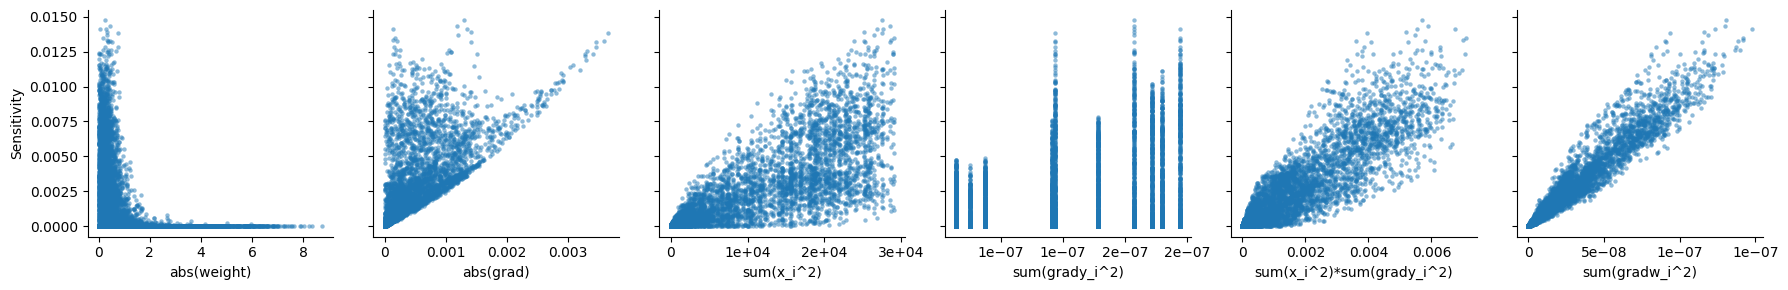

In [128]:
_, axs = plt.subplots(ncols=len(stats), figsize=(3*len(stats), 3), sharey=True)
with torch.no_grad():
    for (title, t), ax in zip(stats, axs):
        ax.scatter(t.flatten(), sensitivity_map.flatten(), alpha=.5, lw=0, s=10)
        ax.xaxis.set_major_formatter("{x:.1g}")
        ax.set_xlabel(title)
axs[0].set_ylabel("Sensitivity")
axs[0].figure.tight_layout()

## Sensitivity (relative)

In [138]:
sensitivity_map = torch.full_like(model.predict, -torch.inf)

delta = 2
n = images.shape[0]
# n = 5000
ref = model(images[:n], targets[:n])
model._x = model._y = None
model2 = copy.deepcopy(model)
with torch.no_grad():
    for idx in tqdm.tqdm(list(range(model.predict.nelement()))):
        m = sensitivity_map.flatten()
        for d in [delta, 1/delta]:
            model2.predict.data[...] = model.predict
            model2.predict.data.flatten()[idx] *= d
            m[idx] = torch.maximum(m[idx], model2(images[:n], targets[:n]) - ref)

100%|███████████████████████████████████████| 7840/7840 [01:56<00:00, 67.16it/s]


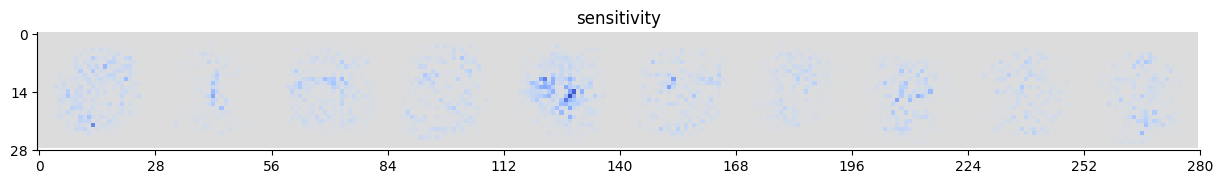

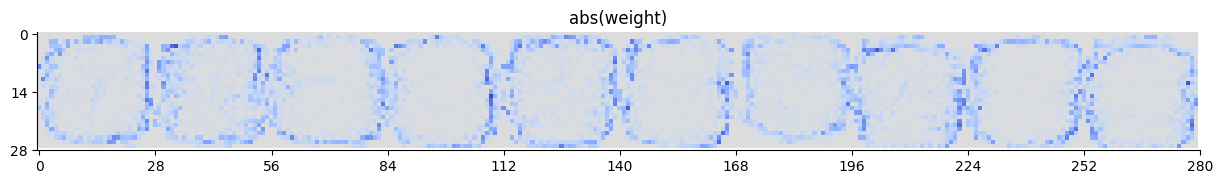

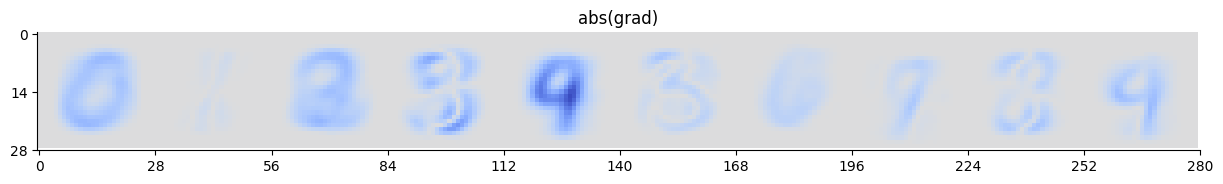

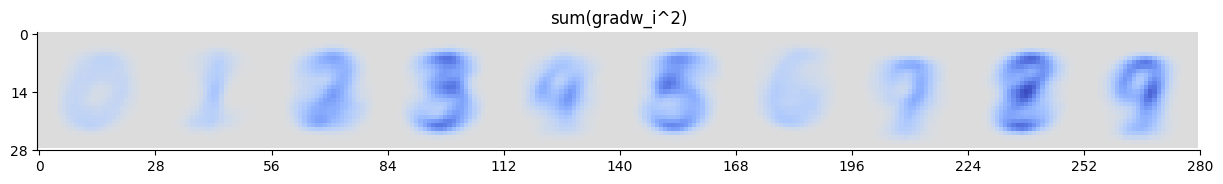

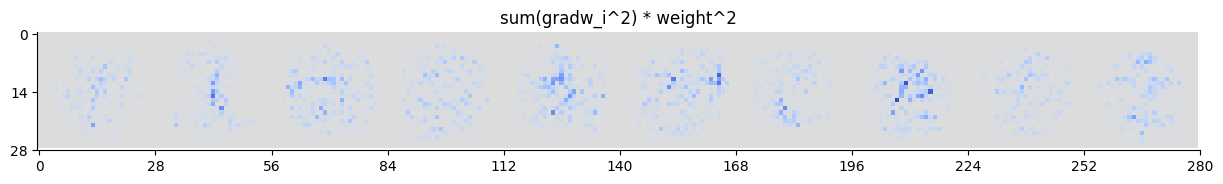

In [139]:
model.zero_grad()
loss = model(images, targets)
loss.backward()
sum_gradw2 = (model._x.pow(2).T @ model._y.grad.pow(2))
sum_x2 = torch.tile(model._x.pow(2).sum(0).view(28, 28, 1), (1, 1, 10))
sum_grady2 = torch.tile(model._y.grad.pow(2).sum(0).view(1, 1, 10), (28, 28, 1))

def showw(t: Tensor) -> matplotlib.axes.Axes:
    _, ax = plt.subplots(figsize=(15, 3))
    amax = t.abs().max()
    ax.imshow(t.view(28, 28, 10).permute(0, 2, 1).flatten(1).detach(), vmin=-amax, vmax=amax, cmap="coolwarm_r")
    ax.set_xticks(range(0, 28*10+1, 28))
    ax.set_yticks([0, 14, 28])
    return ax

stats = [
    ("abs(weight)", model.predict.abs()),
    ("abs(grad)", model.predict.grad.abs()),
    # ("sum(x_i^2)", sum_x2),
    # ("sum(grady_i^2)", sum_grady2),
    # ("sum(x_i^2)*sum(grady_i^2)", sum_x2 * sum_grady2),
    ("sum(gradw_i^2)", sum_gradw2),
    ("sum(gradw_i^2) * weight^2", sum_gradw2 * model.predict.pow(2)),
]

showw(sensitivity_map).set_title("sensitivity")
for title, stat in stats:
    showw(stat).set_title(title)

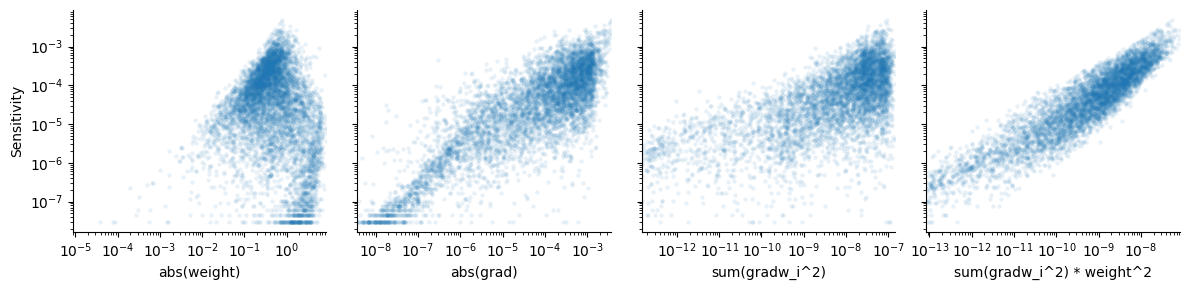

In [140]:
_, axs = plt.subplots(ncols=len(stats), figsize=(3*len(stats), 3), sharey=True)
with torch.no_grad():
    for (title, t), ax in zip(stats, axs):
        ax.scatter(t.flatten(), sensitivity_map.flatten(), alpha=.1, lw=0, s=10)
        ax.xaxis.set_major_formatter("{x:.1g}")
        ax.set_xlabel(title)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim((t.max()/1e6, t.max()))
axs[0].set_ylabel("Sensitivity")
axs[0].figure.tight_layout()